In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import joblib
import sys
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')


In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# nltk.download('all')

In [2]:
sys.path.append(str(Path("../utils/preprocessing.py").resolve().parent.parent / "utils"))
from preprocessing import preprocess_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv("../data/spam_Emails_data.csv")
df.head()

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...
1,Ham,got ice thought look az original message ice o...
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...
3,Spam,start increasing your odds of success & live s...
4,Ham,author jra date escapenumber escapenumber esca...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193852 entries, 0 to 193851
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   193852 non-null  object
 1   text    193850 non-null  object
dtypes: object(2)
memory usage: 3.0+ MB


In [6]:
df["label"].unique()

array(['Spam', 'Ham'], dtype=object)

In [7]:
df["y"] = df['label'].map({'Spam': 1, 'Ham': 0})
df

,label,text,y
0,Spam,viiiiiiagraaaa\nonly for the ones that want to...,1
1,Ham,got ice thought look az original message ice o...,0
2,Spam,yo ur wom an ne eds an escapenumber in ch ma n...,1
3,Spam,start increasing your odds of success & live s...,1
4,Ham,author jra date escapenumber escapenumber esca...,0
...,...,...,...
193847,Ham,on escapenumber escapenumber escapenumber rob ...,0
193848,Spam,we have everything you need escapelong cialesc...,1
193849,Ham,hi quick question say i have a date variable i...,0
193850,Spam,thank you for your loan request which we recie...,1


In [8]:
df.duplicated().sum()

0

In [9]:
df["label"].value_counts()

label
Ham     102160
Spam     91692
Name: count, dtype: int64

In [10]:
print("\nNumber of NaN values in 'text' column:", df['text'].isna().sum())
print("Types in 'text' column:\n", df['text'].apply(type).value_counts())


Number of NaN values in 'text' column: 2
Types in 'text' column:
 text
<class 'str'>      193850
<class 'float'>         2
Name: count, dtype: int64


In [11]:
df['text'] = df['text'].fillna('')  # NaN --> ''
df['text'] = df['text'].astype(str)

In [12]:
df_sample = df.sample(n=50000, random_state=42)

In [13]:
# Apply preprocessing to the text column
df_sample['cleaned_text'] = df_sample['text'].apply(preprocess_text)

In [14]:
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
X = tfidf.fit_transform(df_sample['cleaned_text']).toarray()
y = df_sample['y']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [16]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy', n_jobs=-1)

print("\nCross-Validation Scores (Accuracy):", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Scores:", cv_scores.std())


Cross-Validation Scores (Accuracy): [0.9708 0.9698 0.9684 0.9684 0.9688]
Average CV Accuracy: 0.9692399999999999
Standard Deviation of CV Scores: 0.0009329523031752329


In [17]:
# Train Random Forest Classifier on the training set
rf_model.fit(X_train, y_train)

# Predictions and Evaluation on the test set
y_pred = rf_model.predict(X_test)

In [18]:
print("\nAccuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report on Test Set:\n", classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Accuracy on Test Set: 0.9704666666666667

Classification Report on Test Set:
               precision    recall  f1-score   support

         Ham       0.97      0.97      0.97      7978
        Spam       0.97      0.97      0.97      7022

    accuracy                           0.97     15000
   macro avg       0.97      0.97      0.97     15000
weighted avg       0.97      0.97      0.97     15000



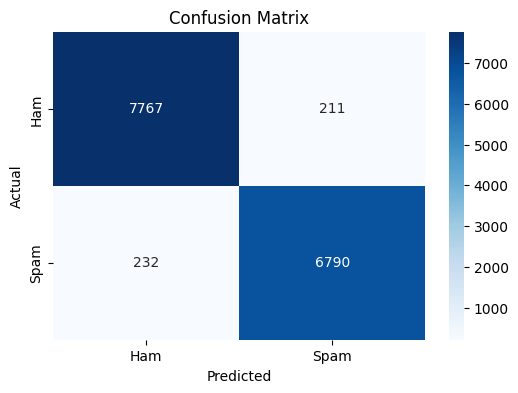

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

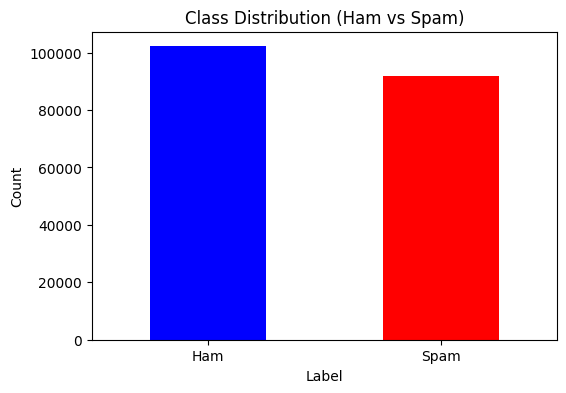

In [20]:
# Visualize Class Distribution
plt.figure(figsize=(6, 4))
df['label'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Class Distribution (Ham vs Spam)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
with open("../models/rf_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

with open("../models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)